In [1]:
from torchreg import AffineRegistration
import numpy as np
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import nibabel as nib
import torch
import torch.nn.functional as F

In [2]:
def dice_loss(x1, x2):
    dim = [2, 3, 4] if len(x2.shape) == 5 else [2, 3]
    inter = torch.sum(x1 * x2, dim=dim)
    union = torch.sum(x1 + x2, dim=dim)
    return 1 - (2. * inter / union).mean()
reg = AffineRegistration(dissimilarity_function=dice_loss, optimizer=torch.optim.Adam, is_3d=True,iterations=(500, 200), 
                         scales=(2, 1))

In [3]:
# Based on https://codingfisch.github.io/2023/08/09/affine-registration-in-12-lines-of-code.html
    
path_database = "/mnt/d/Poly/ISBI_2015/Test_Torchreg/data/"
image_data_01_t2 = nib.load(path_database  + 'sub01_ses01_t2.nii.gz')
image_sub01_ses01_t2 = np.array(image_data_01_t2.get_fdata())

image_data_01_brainmask = nib.load(path_database  + 'sub01_ses01_brainmask.nii.gz')
image_sub01_ses01_brainmask = np.array(image_data_01_brainmask.get_fdata())

image_data_01_pd = nib.load(path_database  + 'sub01_ses01_pd.nii.gz')
image_sub01_ses01_pd = np.array(image_data_01_pd.get_fdata())

image_data_02_t2 = nib.load(path_database  + 'sub01_ses02_t2.nii.gz')  # Fixed
image_sub01_ses02_t2 = np.array(image_data_02_t2.get_fdata())


image_data_02_ses01_t2 = nib.load(path_database  + 'sub02_ses01_t2.nii.gz')
image_sub02_ses01_t2 = np.array(image_data_02_ses01_t2.get_fdata())

image_data_02_ses01_pd = nib.load(path_database  + 'sub02_ses01_pd.nii.gz')
image_sub02_ses01_pd = np.array(image_data_02_ses01_pd.get_fdata())

image_data_02_brainmask = nib.load(path_database  + 'sub02_ses01_brainmask.nii.gz')
image_sub02_ses01_brainmask = np.array(image_data_02_brainmask.get_fdata())


## Intersession multimodal registration 
### Image Moving (PD)

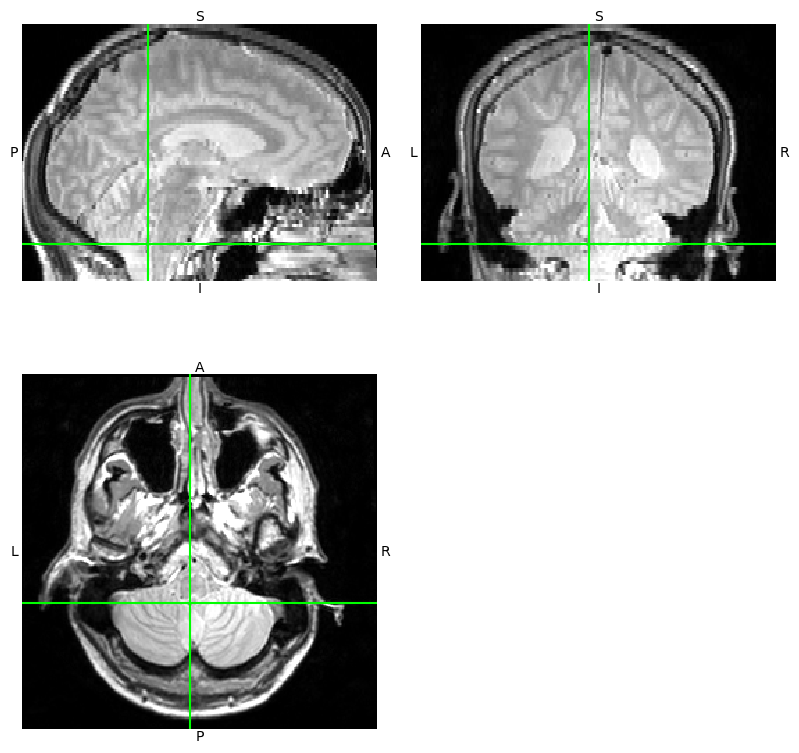

In [4]:
image_data_01_pd.orthoview();

### Image Fixed - Subject01_ses02_T2 - (for all experiments)

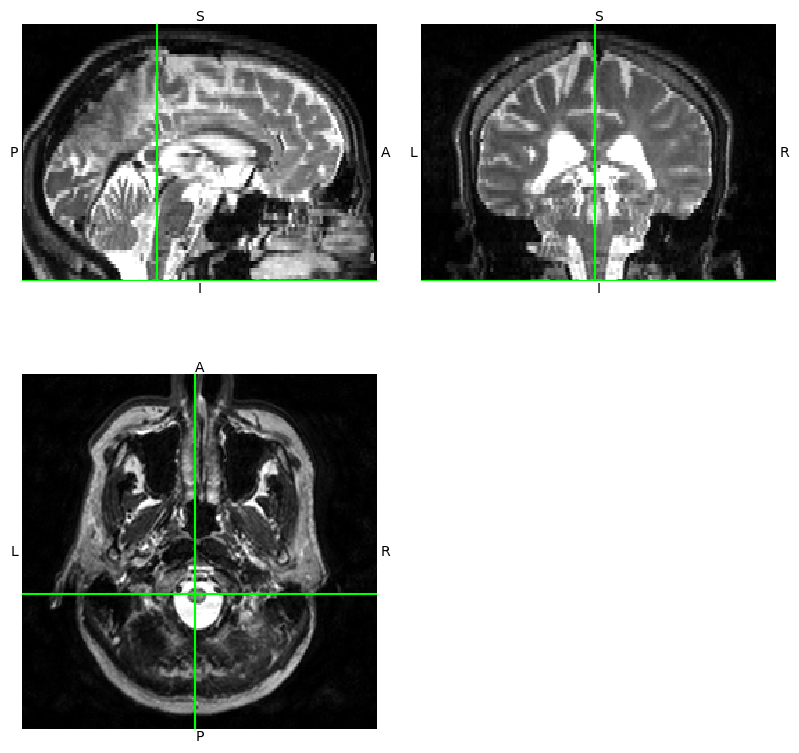

In [5]:
image_data_02_t2.orthoview();

In [6]:
moving=torch.from_numpy(image_sub01_ses01_pd).float()
static = torch.from_numpy(image_sub01_ses02_t2).float()

reg = AffineRegistration(dissimilarity_function=dice_loss, optimizer=torch.optim.Adam,is_3d=True,iterations=(500, 200), 
                         scales=(3, 2))
moving_max = moving.max()
static_max = static.max()

moving_normed = moving / moving_max
static_normed = static / static_max

moved = reg(moving_normed[None, None], static_normed[None, None])
moved = moved[0, 0]
moved = moving_max * moved

Shape: [1, 1, 85, 85, 23]; Dissimiliarity: 0.7665084004402161: 100%|██████████████████████████████| 500/500 [00:08<00:00, 57.27it/s]
Shape: [1, 1, 128, 128, 35]; Dissimiliarity: 0.7621675133705139: 100%|████████████████████████████| 200/200 [00:10<00:00, 19.69it/s]


### Output: ses01_PD to ses02_T2

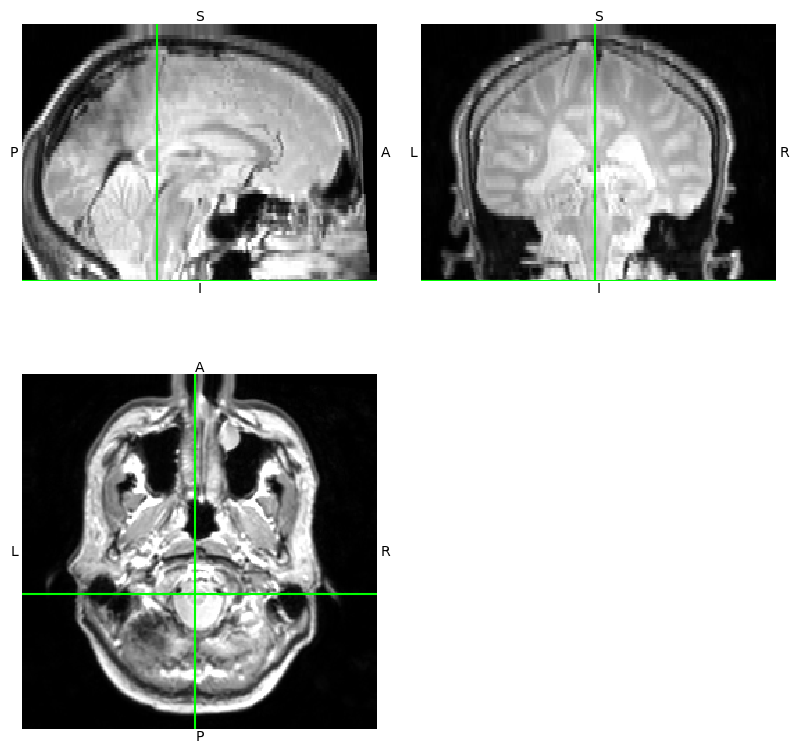

In [7]:
moved_nii = nib.Nifti1Image(moved.cpu().numpy(), image_data_02_t2.affine)
moved_nii.orthoview();

In [8]:
nib.save(moved_nii, path_database + "sub01_PD_to_ses02_t2.nii.gz")

## Use of Transform warp 
### Image Moving (Brainmask from sub01_ses01)

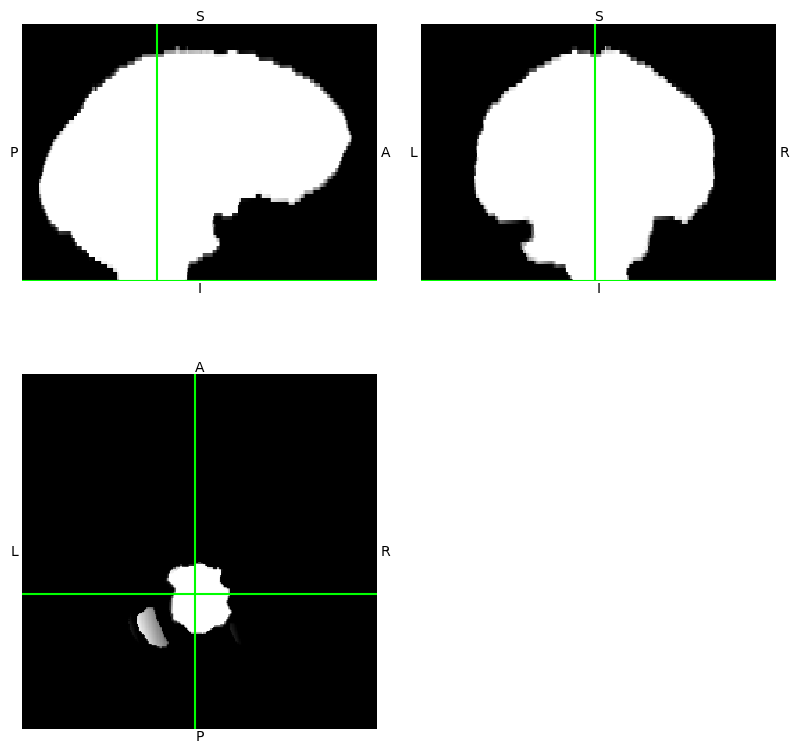

In [9]:
moving_brainmask=torch.from_numpy(image_sub01_ses01_brainmask).float()
moving_tranfo = reg.transform(moving_brainmask[None, None].clone())
moved = moving_tranfo[0, 0]
moved = nib.Nifti1Image(moved.cpu().numpy(), image_data_02_t2.affine)
moved.orthoview();

In [10]:
nib.save(moved, path_database + "sub01_brainmask_to_ses02_t2.nii.gz")

## Intersubject multimodal in paralell registration 
### Image Moving (sub02_ses01 PD and T2)

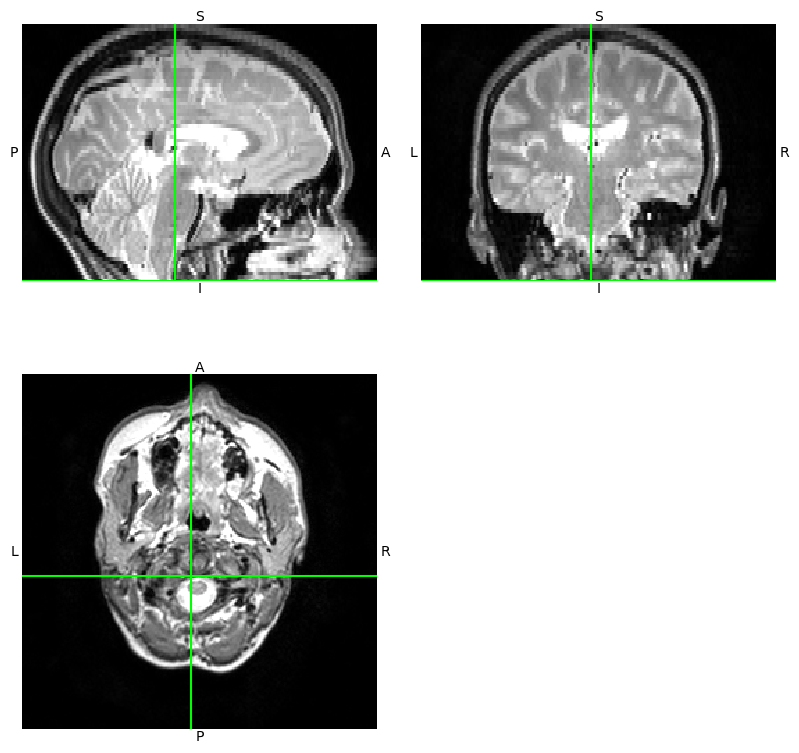

In [11]:
image_data_02_ses01_pd.orthoview();

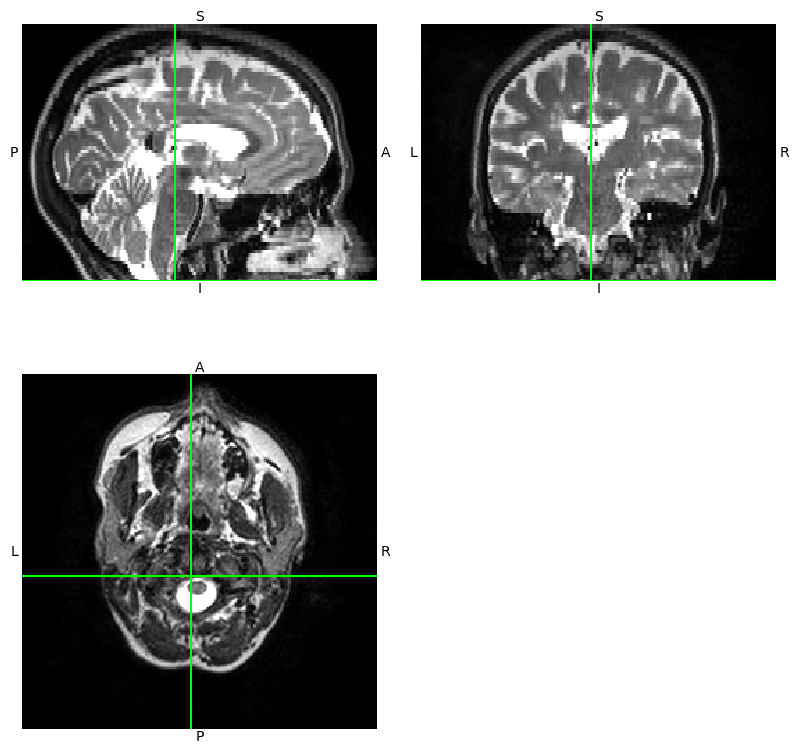

In [12]:
image_data_02_ses01_t2.orthoview();

In [13]:
moving1=torch.from_numpy(image_sub02_ses01_t2).float()
moving2=torch.from_numpy(image_sub02_ses01_pd).float()
static = torch.from_numpy(image_sub01_ses02_t2).float()

movings = torch.cat([moving1[None, None], moving2[None, None]], dim=1)
statics = torch.cat([static[None, None], static[None, None]], dim=1)

movings_max, statics_max = movings.max(), statics.max()
reg = AffineRegistration(dissimilarity_function=dice_loss, optimizer=torch.optim.Adam,is_3d=True,iterations=(500, 200), 
                         scales=(3, 2))
#reg = AffineRegistration(is_3d=True)
moved = reg(movings / movings_max, statics / statics_max)
moved = movings_max * moved
moved1, moved2 = moved[0, 0], moved[0, 1]

affine = reg.get_affine()
print(affine)

Shape: [1, 2, 85, 85, 23]; Dissimiliarity: 0.7891051769256592: 100%|██████████████████████████████| 500/500 [00:11<00:00, 45.21it/s]
Shape: [1, 2, 128, 128, 35]; Dissimiliarity: 0.7872289419174194: 100%|████████████████████████████| 200/200 [00:13<00:00, 14.39it/s]


tensor([[[ 0.9580, -0.0762, -0.0464,  0.0930],
         [-0.0425,  0.8985,  0.0324, -0.0077],
         [-0.0087,  0.0023,  0.8909, -0.0023]]])


### Output: Sub02_PD to Sub01_ses02_T2

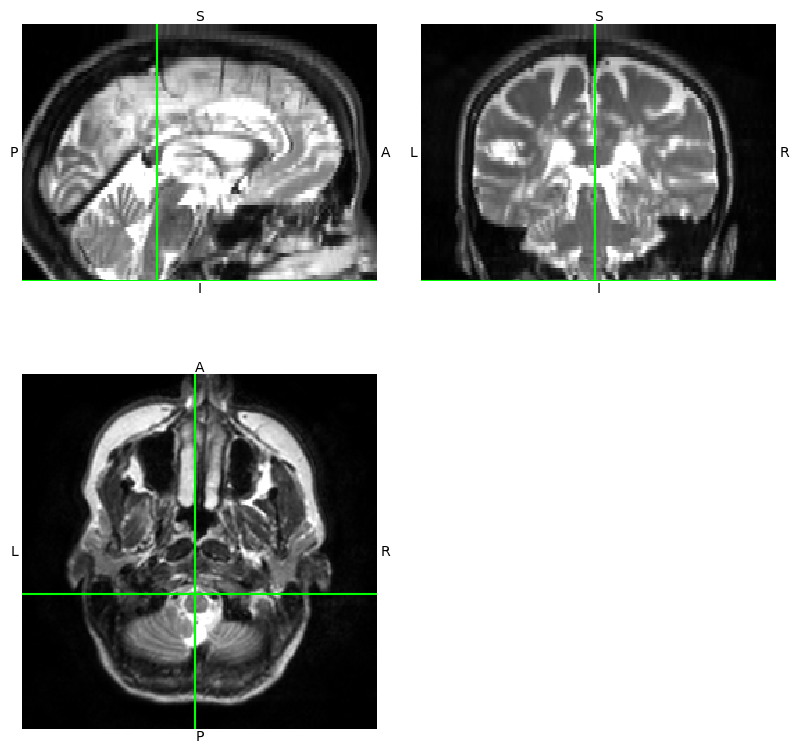

In [14]:
moved1_view = nib.Nifti1Image(moved1.cpu().numpy(), image_data_02_t2.affine)
moved1_view.orthoview();

In [15]:
nib.save(moved1_view, path_database + "sub02_pd_to_ses02_t2.nii.gz")

### Output: Sub02_T2 to Sub01_ses02_T2

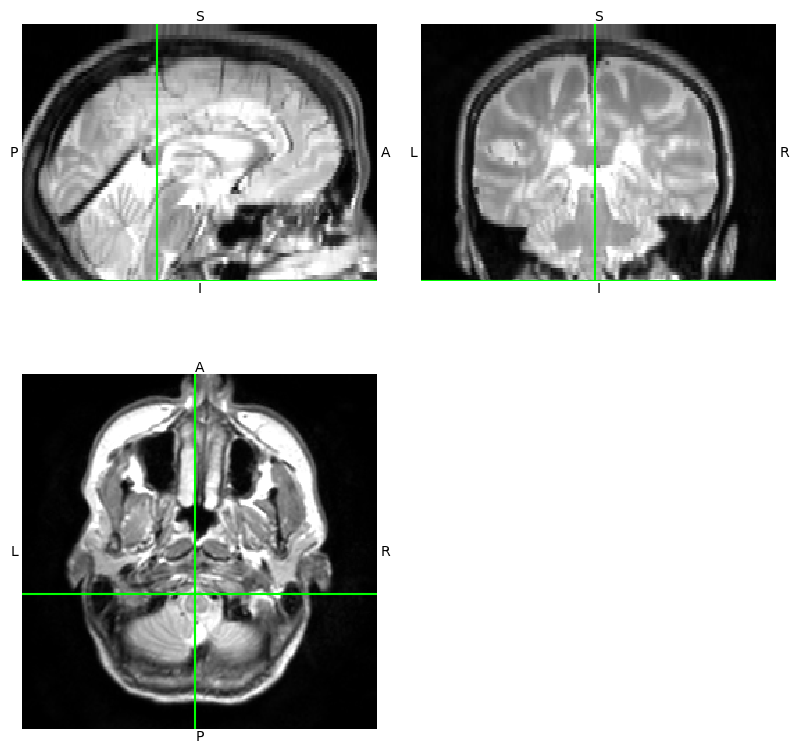

In [16]:
moved2_view = nib.Nifti1Image(moved2.cpu().numpy(), image_data_02_t2.affine)
moved2_view.orthoview();

In [17]:
nib.save(moved2_view, path_database + "sub02_t2_to_ses02_t2.nii.gz")

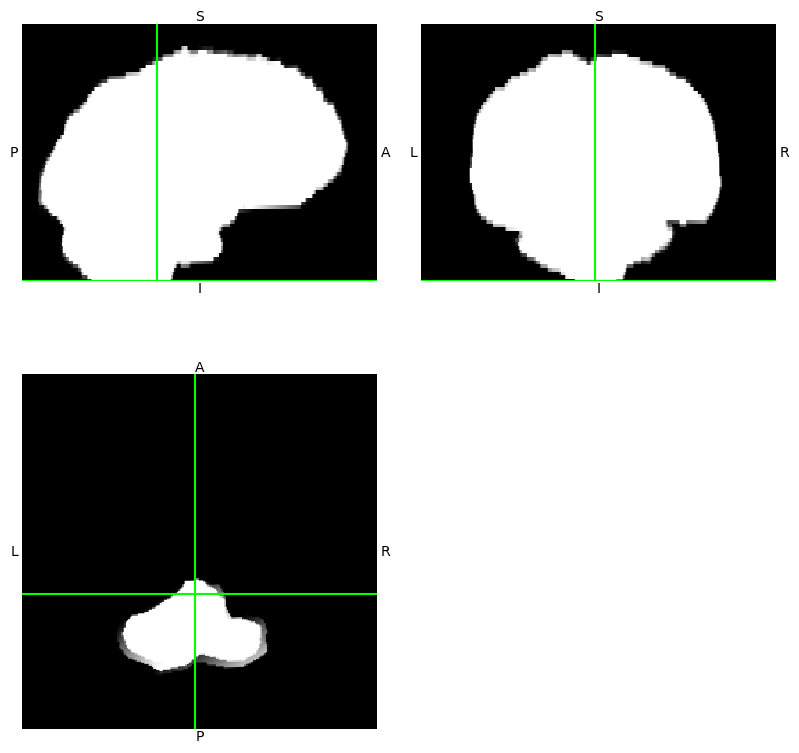

In [18]:
moving_brainmask=torch.from_numpy(image_sub02_ses01_brainmask).float()
moving_tranfo = reg.transform(moving_brainmask[None, None].clone())
moved = moving_tranfo[0, 0]
moved = nib.Nifti1Image(moved.cpu().numpy(), image_data_02_t2.affine)
moved.orthoview();

In [19]:
nib.save(moved, path_database + "sub02_brainmask_to_Sub01_ses02_t2.nii.gz")